# Ejercicio 1. Transfer Learning con VGG16

Ejercicio 1 del tutorial de Transfer Learning.

GPT2: Diseño y Gestión de Proyectos en Data Science II.
[Máster en Data Science y Big Data](http://masterds.es/) de la [Universidad de Sevilla](http://www.us.es). 

25/06/2020. Profesor: [Miguel Ángel Martínez del Amor](http://www.cs.us.es/~mdelamor)

Este ejercicio puede ayudar a mejorar las habilidades con Keras. Para ello se propone emplear el modelo VGG16, el cual es más sencillo y que ya habéis visto en clase (o accediendo [aquí](https://github.com/fsancho/DL/blob/master/4.%20Redes%20Convolucionales/4.3.%20CNN%20Preentrenadas.ipynb)). 

## 1. Importación de librerías y funciones auxiliares <a class="anchor" id="transferimp"></a>

In [ ]:
# Antes de nada, si estás en Google Colab, evalúa esta celda:
import os
work_dir = "/content/TL-tutorial/"
if os.getcwd() != work_dir:
    !git clone https://github.com/miguelamda/TL-tutorial.git
os.chdir(work_dir)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

A continuación la importación de la API de Keras. Como **primer ejercicio**, busca como se llama la función que carga el modelo VGG16, e importala en la celda siguiente.

In [3]:
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop

# Importa a continuación la función que carga el modelo VGG16
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

tf.__version__

Using TensorFlow backend.


'2.2.0'

Vamos a usar las mismas funciones auxiliares que en el tutorial, las tienes a continuación, todas en una sola celda para definirlas más rápido.

In [4]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Crea una figura con sub-gráficas.
    fig, axes = plt.subplots(3, 3)

    # Ajusta el espacio vertical.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Tipo de interpolación.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # Puede haber menos de 9 imágenes, nos aseguramos que no falle.
        if i < len(images):
            # Dibuja imagen.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Number de la true class.
            cls_true_name = class_names[cls_true[i]]

            # Muestra clases predichas y verdaderas.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Nombre de la clase predicha.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Muestra las clases con la etiqueta en el eje x.
            ax.set_xlabel(xlabel)
        
        # Elimina ticks en la gráfica.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Asegurar que la gráfica se muestra correctamente con gráficos múltiples
    # en una sola celda Notebook.
    plt.show()
    
# Importa una función de sklearn para calcular la matriz de confusión.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred es un array del número de la clase predicha para
    # todas las imágenes del conjunto de test.

    # Obtiene la matriz de confusión usando sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class para el conjunto de test.
                          y_pred=cls_pred)  # Predicted class.

    print("Matriz de confusión:")
    
    # Imprime la matriz de confusión como texto.
    print(cm)
    
    # Imprime los nombres de clases para facilitar la referencia.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))
        
def plot_example_errors(cls_pred):
    # cls_pred es un array del número de la clase predicha para
    # todas las imágenes en el conjunto de test.

    # Array booleano indicando si la clase predicha es incorrecta.
    incorrect = (cls_pred != cls_test)

    # Obtiene las rutas de ficheros para las imágenes que son clasificadas incorrectamente.
    image_paths = np.array(image_paths_test)[incorrect]

    # Carga las primeras 9 imágenes.
    images = load_images(image_paths=image_paths[0:9])
    
    # Obtiene las clases predichas para esas imágenes.
    cls_pred = cls_pred[incorrect]

    # Obtiene las clases de verdad para esas imágenes.
    cls_true = cls_test[incorrect]
    
    # Muestra las 9 imágenes que hemos cargado y sus correspondientes clases.
    # Tenemos solo 9 imágenes, por lo que no hace falta dividirlas otra vez.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def example_errors(model=None):
    # El generador de datos de Keras para el conjunto de test se debe resetear
    # antes del procesamiento. Esto es porque el generador va a iterar
    # infintamente y mantendrá un índice interno en el dataset.
    # Por tanto, se podrá comenzar por el medio del conjunto de test si no lo
    # reseteamos primero. Esto imposibilita encajar las clases predichas con
    # las imágenes de entrada. Si reseteamos el generador, entonces siempre
    # compienza por el comienzo, así que sabemos exáctamente qué imágenes
    # de entrada se están usando.
    if model is None:
        model = new_model
        
    generator_test.reset()
    
    # Predecir las clases para todas las imágenes del conjunto de test.
    y_pred = model.predict_generator(generator_test,
                                      steps=steps_test)

    # Convertir las clases predichas de arrays a enteros.
    cls_pred = np.argmax(y_pred,axis=1)

    # Muestra los ejemplos de imágenes mal clasificados.
    plot_example_errors(cls_pred)
    
    # Muestra la matriz de confusión.
    print_confusion_matrix(cls_pred)
    
def load_images(image_paths):
    # Carga las imágenes de disco.
    images = [plt.imread(path) for path in image_paths]

    # Convierte a un array de numpy y lo devuelve.
    return np.asarray(images)

def plot_training_history(history):
    # Obtiene la precisión de clasificación y el valor de pérdida para el
    # conjunto de entrenamiento.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # También para el conjunto de validación (solo usamos el del conjunto de test).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Muestra el valor del accuracy y pérdida para el conjunto de entrenamiento.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Muestra el del conjunto de test.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Muestra el título y la leyenda.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Se asegura de mostrar la gráfica correctamente.
    plt.show()

## 2. El Modelo Pre-Entrenado: VGG16 

Lo siguiente crea una instancia del modelo VGG16 pre-entrenado usando la API de [Keras](https://keras.io/). Esto descarga automáticamente los archivos necesarios si no los tiene ya. 

El modelo VGG16 contiene una parte convolucional y una parte completamente conectada (o densa) que se utiliza para la clasificación. Si `include_top=True` entonces se descarga todo el modelo VGG16 que tiene unos 528 MB. Si `include_top=False` entonces sólo se descarga la parte convolucional del modelo VGG16, que es de sólo 57 MB. Descaragaremos esta última versión.

![VGG model](https://github.com/miguelamda/TL-tutorial/blob/master/images/11_vgg_model.png?raw=1)

In [5]:
vggmodel = VGG16(include_top=True)

## 3. El Dataset: Knifey-Spoony 

Carga el dataset tal y como se vió en el tutorial. A continuación las líneas de código.

In [6]:
# Carga el dataset empleando el fichero kinfey.py
import knifey

# Descarga el dataset, si no se ha descargado ya
knifey.maybe_download_and_extract()

# Adapta la estructura de carpetas para Keras
knifey.copy_files()

# Define las rutas a los directorios de train y test
train_dir = knifey.train_dir
test_dir = knifey.test_dir

Data has apparently already been downloaded and unpacked.
Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


## 4. El Canal de Entrada

Para definir el pipeline de entrada para el modelo, primero necesitamos saber la forma de los tensores esperados como entrada por el modelo VGG16 pre-entrenado. En este caso, ¿qué forma tienen las imágenes de entrada?

In [7]:
input_shape = vggmodel.layers[0].output_shape[1:3]
input_shape

(224, 224)

Define a continuación un *generador de datos* que haga aumentado mediante transformaciones aleatorias. Para VGG16, es necesario tan solo reescalar los píxeles a 1.0/255, así que no hace falta usar la función de preprocesamiento de entrada.

In [8]:
datagen_train = ImageDataGenerator(
      rescale=1./255, # En VGG16 el preprocesamiento es tan solo esta normalización
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale=1./255)

Debido a que el modelo VGG16 es muy grande, el tamaño del batch no puede ser demasiado grande.

In [9]:
batch_size = 20

Podemos guardar las imágenes transformadas aleatoriamente durante el entrenamiento, para comprobar si han sido demasiado distorsionadas, por lo que tendríamos que ajustar los parámetros del generador de datos anterior.

In [10]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

Ahora creamos el generador de datos real que leerá los archivos del disco, redimensionará las imágenes y devolverá un lote aleatorio.

In [11]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 4170 images belonging to 3 classes.
Found 530 images belonging to 3 classes.


Debido a que nuestro conjunto de pruebas contiene 530 imágenes y el tamaño del batch está configurado en 20, el número de pasos es 26,5 para un procesamiento completo del conjunto de pruebas.

In [12]:
steps_test = generator_test.n / batch_size
steps_test

26.5

## 5. Clases del Conjunto de Datos 

Obtengamos las rutas de los ficheros para todas las imágenes en los conjuntos de entrenamiento y de pruebas. Nos vendrá bien para las funciones auxiliares para visualizar ejemplos del conjunto de entrenamiento y de test.

In [13]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Obtengamos las clasificaciones reales (el número correspondiente) de cada imagen en los conjuntos de training y test.

In [14]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Obtengamos los nombres correspondientes de las clases del dataset y el número de ellos.

In [15]:
class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes
num_classes

3

Dado que el conjunto de datos Knifey-Spoony está bastante desequilibrado porque tiene pocas imágenes de tenedores, más imágenes de cuchillos y muchas más imágenes de cucharas. Así que vamos a calcular **pesos** que equilibrarán adecuadamente el conjunto de datos.

In [16]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

## 6. Transfer Learning

Primero imprimimos un resumen del modelo VGG16 para poder ver los nombres y tipos de sus capas, así como las formas de los tensores que fluyen entre las capas.

In [17]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

En este ejercicio vamos a extraer la parte convolucional de forma personalizada, es decir, desde la entrada hasta una capa deseada (de esta forma podrás hacer transfer learning desde otras capas). Comprueba como difiere esto a como lo habéis hecho en clase anteriormente (o [aquí](https://github.com/fsancho/DL/blob/master/4.%20Redes%20Convolucionales/4.3.%20CNN%20Preentrenadas.ipynb)).

Podemos ver que la última capa convolucional se llama 'block5_pool', y podemos usar Keras para obtener una referencia a dicha capa.

In [18]:
transfer_layer = vggmodel.get_layer('block5_pool')

Nos referiremos a esta capa como la Capa de Transferencia (**Transfer Layer**), puesto que su salida será re-enrutada a nuestra nueva red neuronal completamente conectada que hará la clasificación final sobre el Knifey-Spoony dataset.

La salida de la capa de transferencia tiene la siguiente forma:

In [19]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(None, 7, 7, 512) dtype=float32>

Es muy sencillo crear un nuevo modelo usando la API de Keras. Primero tomamos la parte del modelo VGG16 desde su capa de entrada hasta la salida de la capa de transferencia. Podemos llamarlo el modelo convolucional, porque consiste en todas las capas convolucionales del modelo VGG16.

In [20]:
conv_model = Model(inputs=vggmodel.input,
                   outputs=transfer_layer.output)

Podemos entonces usar Keras para construir un modelo nuevo encima de este.

In [21]:
# Creamos un nuevo modelo Secuencial de Keras
nuevo_modelo = Sequential()

# Añadimos la parte convolucional del modelo VGG16 de arriba
nuevo_modelo.add(conv_model)

# Aplanamos la salida del modelo VGG16 dado que ésta viene
# de una capa convolucional.
nuevo_modelo.add(Flatten())

# Añade una capa densa (es decir, totalmente conectada o fully-connected).
# Esto es para combinar las características que el modelo VGG16 ha
# reconocido en la imagen. Usa como función de activación ReLu.
nuevo_modelo.add(Dense(1024, activation='relu'))

# Añade una capa dropout el cual prevendrá el sobreajuste y mejorará
# la capacidad de generalización en datos desconocidos (es decir, el 
# conjunto de test). Usa un ratio de 0.5
nuevo_modelo.add(Dropout(0.5))

# Añade la capa final para la clasificación real, usando softmax.
nuevo_modelo.add(Dense(num_classes, activation='softmax'))

Utilizamos el optimizador Adam con una tasa de aprendizaje bastante baja de 1e-5. La tasa de aprendizaje podría ser mayor, pero si se intenta entrenar más capas del modelo original VGG16, entonces la velocidad de aprendizaje debería ser bastante baja, de lo contrario los pesos preentrenados del modelo VGG16 se distorsionarán y no podrá aprender.

In [22]:
optimizer = Adam(learning_rate=1e-5)

Tenemos 3 clases en el Knifey-Spoony dataset, por lo que Keras necesita usar una **función de pérdida** (loss function).

In [23]:
loss = 'categorical_crossentropy'

La única **métrica de rendimiento** en la que estamos interesados es en la precisión de clasificación (clasiffication accuracy).

In [24]:
metrics = ['categorical_accuracy']

Función auxiliar para imprimir si la capa en el modelo VGG16 debe ser entrenada.

In [25]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
    
print_layer_trainable()

False:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


Por defecto, todas las capas del modelo VGG16 son entrenables.

En transfer learning estamos inicialmente interesados tan solo en reusar el modelo VGG16 tal cual, como un **extractor de características**, por lo que deshabilitaremos el entrenamiento en todas sus capas.

In [26]:
conv_model.trainable = False

In [27]:
for layer in conv_model.layers:
    layer.trainable = False

In [28]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


Una vez que hayamos cambiado si las capas del modelos son entrenables, necesitamos compilarlo para que los cambios surtan efecto.

In [29]:
nuevo_modelo.compile(optimizer=optimizer, loss=loss, metrics=metrics)

A continuación entrenamos el nuevo modelo, lo que se hace con tan solo una llamada a una función en la API de Keras. Definimos 20 épocas y 100 pasos por época (ya que tenemos batches de 20).

In [30]:
epochs = 20
steps_per_epoch = 100
history = nuevo_modelo.fit_generator(generator=generator_train,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     class_weight=class_weight,
                                     validation_data=generator_test,
                                     validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 46s 457ms/step - loss: 1.1245 - categorical_accuracy: 0.4500 - val_loss: 0.7292 - val_categorical_accuracy: 0.7547
Epoch 2/20
100/100 [==============================] - 39s 393ms/step - loss: 0.9389 - categorical_accuracy: 0.5492 - val_loss: 0.7426 - val_categorical_accuracy: 0.8283
Epoch 3/20
100/100 [==============================] - 41s 413ms/step - loss: 0.8218 - categorical_accuracy: 0.6256 - val_loss: 0.6266 - val_categorical_accuracy: 0.7226
Epoch 4/20
100/100 [==============================] - 39s 389ms/step - loss: 0.7926 - categorical_accuracy: 0.6440 - val_loss: 0.6802 - val_categorical_accuracy: 0.8528
Epoch 5/20
100/100 [==============================] - 40s 401ms/step - loss: 0.7220 - categorical_accuracy: 0.6755 - val_loss: 0.7621 - val_categorical_accuracy: 0.8585
Epoch 6/20
100/100 [==============================] - 39s 394ms/step - loss: 0.6904 - categorical_accuracy: 0.6980 - val_loss: 0.8826 - val_categorical_acc

Mostremos la gráfica de evolución de las métricas.

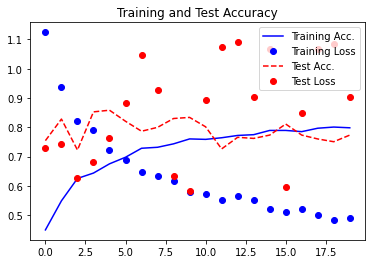

In [31]:
plot_training_history(history)

Después del entrenamiento también podemos evaluar el rendimiento del nuevo modelo en el conjunto de pruebas usando una sola llamada de función en la API de Keras.

In [32]:
result = nuevo_modelo.evaluate_generator(generator_test, steps=steps_test)

In [33]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 77.36%


Podemos representar algunos ejemplos de imágenes mal clasificadas del conjunto de pruebas. 

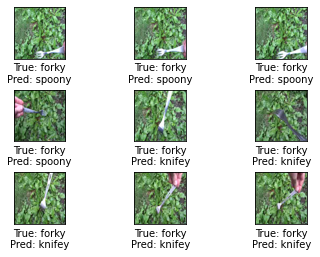

Matriz de confusión:
[[139   8   4]
 [ 56  80   1]
 [ 44   7 191]]
(0) forky
(1) knifey
(2) spoony


In [34]:
example_errors(model=nuevo_modelo)

### 7. Fine-Tuning

Podemos tratar de afinar suavemente algunas de las capas más profundas del modelo VGG16 también. A esto lo llamamos "Ajuste fino", o **Fine Tuning**.

No está claro si Keras usa el booleano `trainable` en cada capa del modelo original VGG16 o si es anulado por el booleano `trainable` en la'meta-capa' que llamamos `conv_layer`. Así que habilitaremos el booleano `trainable` tanto para `conv_layer` como para todas las capas relevantes en el modelo original VGG16.

In [35]:
conv_model.trainable = True

Queremos entrenar las últimas dos capas convolucionales, es decir, cuyos nombres contienen 'block5' o 'block4'.

In [36]:
for layer in conv_model.layers:
    # Booleano de si la capa es entrenable
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Ajusta el booleano de la capa
    layer.trainable = trainable

Podemos comprobar que esto ha actualizado el booleano `trainable` para las capas relevantes.

In [37]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


Usaremos el optimizador Adam con un bajo factor de aprendizaje bajo para el ajuste fino, 1e-7.

In [38]:
optimizer_fine = Adam(lr=1e-7)

Dado que hemos definido un nuevo optimizador y hemos cambiado los booleanos `trainable` para muchas de las capas en el modelo, necesitamos recompilarlo para que los cambios hagan efecto.

In [39]:
nuevo_modelo.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

Continuamos por tanto con el entrenamiento por donde lo dejamos anteriormente, ahora aplicando fine-tuning al modelo VGG16 y el nuevo clasificador. Sigamos con 20 épocas.

In [40]:
history = nuevo_modelo.fit_generator(generator=generator_train,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     class_weight=class_weight,
                                     validation_data=generator_test,
                                     validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 48s 475ms/step - loss: 0.4733 - categorical_accuracy: 0.8141 - val_loss: 0.9531 - val_categorical_accuracy: 0.7642
Epoch 2/20
100/100 [==============================] - 45s 453ms/step - loss: 0.4826 - categorical_accuracy: 0.8060 - val_loss: 0.9522 - val_categorical_accuracy: 0.7660
Epoch 3/20
100/100 [==============================] - 46s 463ms/step - loss: 0.4430 - categorical_accuracy: 0.8241 - val_loss: 0.9639 - val_categorical_accuracy: 0.7660
Epoch 4/20
100/100 [==============================] - 45s 453ms/step - loss: 0.4528 - categorical_accuracy: 0.8180 - val_loss: 0.9268 - val_categorical_accuracy: 0.7642
Epoch 5/20
100/100 [==============================] - 46s 462ms/step - loss: 0.4331 - categorical_accuracy: 0.8265 - val_loss: 0.9301 - val_categorical_accuracy: 0.7698
Epoch 6/20
100/100 [==============================] - 45s 451ms/step - loss: 0.4462 - categorical_accuracy: 0.8231 - val_loss: 0.9464 - val_categorical_acc

Luego podemos mostrar gráficamente los valores de pérdida y precisión de la clasificación a partir del entrenamiento. 

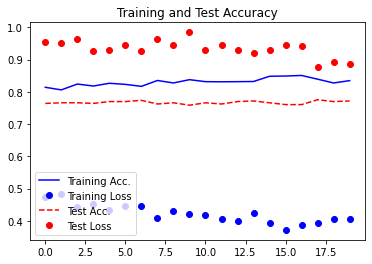

In [41]:
plot_training_history(history)

In [42]:
result = nuevo_modelo.evaluate_generator(generator_test, steps=steps_test)

In [43]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 77.17%


Podemos volver a mostrar algunos ejemplos de imágenes mal clasificadas, y también podemos ver en la matriz de confusión que el modelo sigue teniendo problemas para clasificar correctamente los tenedores.

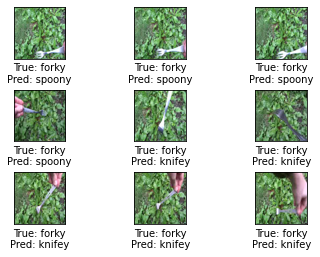

Matriz de confusión:
[[140   7   4]
 [ 58  79   0]
 [ 47   5 190]]
(0) forky
(1) knifey
(2) spoony


In [44]:
example_errors(model=nuevo_modelo)

## License (MIT)

Based on the TensorFlow tutorials by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.